In [1]:
from scipy import *
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import cm

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

Или, переписывая в терминах $\widetilde{\omega}_{r} = \omega_{r} - \frac{\chi_{1,2}}{2}$, $\omega_{0,1}' = \omega_{0,1}+\chi_{0,1}$ и $\chi = \chi_{0,1} -\frac{\chi_{1,2}}{2}$, приходим к формуле: 

\begin{equation}
    H' = \hbar \frac{\omega_{0,1}'}{2}\sigma_{z} +(\hbar\widetilde{\omega}_{r} + \hbar \chi \sigma_{z})a^{\dagger}a
\end{equation}

\begin{equation}
    \chi_{i,j} = \frac{g_{i,j}}{\omega_{i,j} - \omega_{r}}
\end{equation}

где определим силу связи $g_{i,j}$ через оператор $\hat{n} = -i (E_{J}/8E_{C})^{1/4}(\hat{b}-\hat{b}^{\dagger})/\sqrt{2}$, где $\hat{b}$ и $\hat{b}^{\dagger}$ - операторы рождения и уничтожения осциллятора: 

\begin{equation}
    \hbar g_{i,j} = 2\beta e V^{0}_{rms} <i|\hat{n}|j>
\end{equation}

где $\beta = C_{g}/C_{\sum}$ и $V^{0}_{rms} = \sqrt{\hbar \omega_{r}/2C_{r}}$. Рассчитаем $g_{i,j}$ для уровней 0-1 и 1-2: 

$$
g_{0,1} = 2\beta e V^{0}_{rms} \sqrt{\frac{1}{2}}\big(\frac{E_{J}}{8E_{C}}\big)^{1/4}
$$

$$
g_{1,2} = 2\beta e V^{0}_{rms} \sqrt{\frac{2}{2}}\big(\frac{E_{J}}{8E_{C}}\big)^{1/4}
$$


In [401]:
#константы 
e = 1.6e-19
Fi0 = 2e-15
hbar = 6.62e-34

M = 2*pi*1e-11

#параетры установки
Ck = 5e-15
Cg = 2e-15
Cq = 90e-15
Cr = 50e-15#500
Lr = 2e-9
Cs = 2e-15 #чиселко из ниоткуда, но большое


Csum = Cg + Cs
beta = Cg/Csum

E_C = 100e6 
alpha = -E_C #anharmonicity


#параметры из эксперимента 

fr0 = 6e9  #resonator frequency from experiment
Om_r = fr0*2*np.pi
OmQ_exp = 5.3e9 #qubit frequency from experiment


Ql = 3e3
Qc = 2.9e3

tau = 10.**(-9)
phi = pi/6
amp = 1.

#Asymmetric transmon E_J1 = a E_J2
E_J_max = (OmQ_exp+E_C)**2/(8*E_C) #from frequency at sweet spot
a = 10  #inequality of Josephson junctions
E_J1 = E_J_max/(1+a)
E_J2 = a*E_J1
E_Jp = E_J1+E_J2
E_Jm = E_J1-E_J2
d = E_Jm/E_Jp  #SQUID asymmetry


#постоянные коэффициенты
n = 1000 #n of points
Vrms = np.sqrt(hbar*Om_r/2/Cr)
g = 50e6

In [397]:
def Chi(Current):
    Fi = np.pi*Current*M/Fi0 #поток внешнего поля
    E_J = abs(E_J_max*np.cos(Fi)*sqrt(1+d**2*tan(Fi)**2))
    
    Cog = (E_J/8/E_C)**(1/4)
    g01 = 2*beta*e*Vrms*Cog*np.sqrt(1/2)/hbar
    g12 = 2*beta*e*Vrms*Cog/hbar
    
    OmP = sqrt(8*E_C*E_J)
    OmQ = OmP - E_C
    chi01 = g01**2/(OmQ-Om_r)
    chi12 = g12**2/(OmQ-E_C-Om_r)
    chi = g01**2*alpha/((OmQ-Om_r)*(OmQ-E_C-Om_r))#chi01 - chi12/2 #
    return np.abs(chi)

#прошлый вариант
def Chi0(Current): 
    Fi = pi*Current*M/Fi0 #поток внешнего поля
    E_Jp = E_J1+E_J2
    E_Jm = E_J1-E_J2
    d = E_Jm/E_Jp  #SQUID asymmetry
    E_J = abs(E_J_max*np.cos(Fi)*sqrt(1+d**2*tan(Fi)**2))
    omegaP = sqrt(8*E_C*E_J) #плазменная частота 
    omegaEG = omegaP - E_C   #частота перехода кубита e->g
    Delta = np.abs(2*pi*Frequency - omegaEG)# отстройка частоты кубита от частоты резонатора
    Chi = g*g/Delta*(1/(1+Delta/alpha))#dispersive shift
    return Chi



def fr(Current, disp = True):
    if disp:
        fr = fr0 - Chi(Current)#*1e-3
    else: 
        fr = fr0
    return fr
    
    

def fS21(f, Current): 
    A = amp * exp(1j * alpha) * exp(-2*pi*1j*f*tau)
    Qdel = (Ql/abs(Qc))*exp(1j*phi)
    fdel = f/fr(Current) - 1
    Z = 1+2*1j*Ql*fdel
    ideal = 1 - Qdel/Z
    fS21 = A*ideal
    return fS21

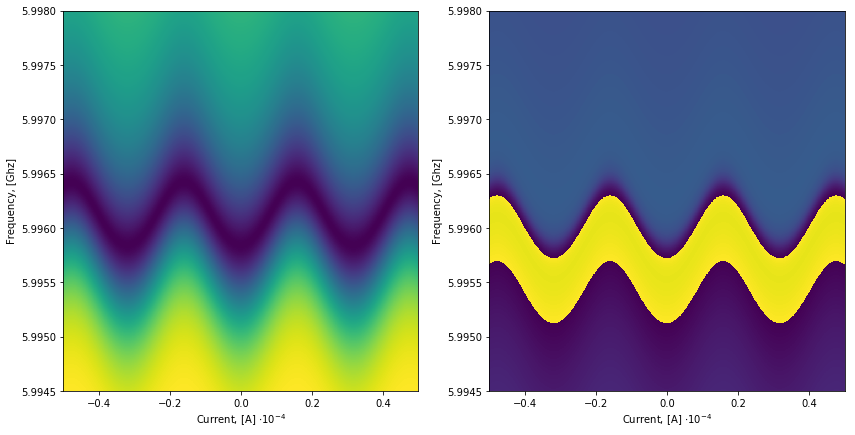

In [402]:
Current = np.linspace(-0.5e-4, 0.5e-4, n)
Frequency = np.linspace(5.9945e9, 5.998e9, n)

S21 = np.zeros((n,n))

XX, YY = np.meshgrid(Frequency, Current)
S21abs_r = np.abs(fS21(XX,YY))
S21arg_r = np.angle(fS21(XX,YY))

fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)    
fig.set_figheight(7)  

ax[0].set_xlabel(r'Current, [A] $\cdot 10^{-4}$')
ax[0].set_ylabel('Frequency, [Ghz]')
ax[1].set_xlabel(r'Current, [A] $\cdot 10^{-4}$')
ax[1].set_ylabel('Frequency, [Ghz]')


ax[0].pcolormesh(Current*1e4, Frequency*1e-9, S21abs_r.T)
ax[1].pcolormesh(Current*1e4, Frequency*1e-9, S21arg_r.T)
#z = ax[0].colorbar()